In [1]:
%matplotlib inline 

# Association Rule Mining
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Association Rule Mining on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
te = TransactionEncoder()

In [5]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [6]:
orders = read_csv_file(my_orders_file)
orders.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


In [7]:
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [8]:
products = read_csv_file(products_file)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments = read_csv_file(departments_file)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles = read_csv_file(aisles_file)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Product Frequencies

In [11]:
product_order_frequency = (orders_products
                           .groupby("product_id")
                           .size()
                           .reset_index(name="count")
                           .sort_values(by=['count'], ascending=False)
                          )
mean_order_frequency = round(product_order_frequency["count"].mean())
least_orderer_products = product_order_frequency.query("count <= " + str(mean_order_frequency))
least_orderer_products.head()

,product_id,count
336,17994,3
474,24830,3
283,15649,3
470,24716,3
578,29780,3


### Often Ordered Products

In [12]:
# Only dropping the entry from the order, not the whole order
often_orders_products =  orders_products[~orders_products['product_id'].isin(least_orderer_products.product_id.tolist())]
often_orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0
27,257077,27068,24184,1,1
28,257078,27068,2295,2,0
29,257079,27068,890,3,0


### Grouping Products in an Order

In [13]:
products_ordered = often_orders_products.merge(products, on="product_id")
products_ordered.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147224,15511,28842,4,1,Bunched Cilantro,16,4
1,464606,49162,28842,8,1,Bunched Cilantro,16,4
2,7384606,779528,28842,9,0,Bunched Cilantro,16,4
3,16676159,1758985,28842,4,0,Bunched Cilantro,16,4
4,16719229,1763480,28842,9,1,Bunched Cilantro,16,4


In [14]:
# Can't just use a comma as a seperator
weird_separator = ",#,"
products_ordered_total = (products_ordered.groupby('order_id')['product_name']
                          .apply(lambda x: "%s" % weird_separator.join(x))
                          .reset_index(name='products')
                         )
products_ordered_total.head()

,order_id,products
0,15511,"Bunched Cilantro,#,Yellow Onions"
1,27068,"Yellow Onions,#,Red Peppers,#,Yellow Bell Pepp..."
2,49162,"Bunched Cilantro,#,Red Peppers,#,Yellow Bell P..."
3,54312,"Organic Apple Juice Boxes,#,Firm Tofu,#,Tomato..."
4,63012,"S'mores Chocolate Ice Cream,#,Cherry Vanilla C..."


### Transaction Database

In [15]:
products_ordered_list = products_ordered_total.products.tolist()
products_ordered_list_of_lists = []
for p in products_ordered_list:
    products_ordered_list_of_lists.append(p.split(weird_separator))
te_ary = te.fit(products_ordered_list_of_lists).transform(products_ordered_list_of_lists,sparse=False)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,100% Whole Wheat Bread,2% Reduced Fat Organic Milk,Apple Cinnamon Cheerios Cereal,Apple Jacks Cereal,Asparagus,Baby Arugula,Baby Kale Mix,Bag of Organic Bananas,Bagel Thins Everything,Banana,...,Ultra Strong Charmin Ultra Strong Toilet Paper 8 Mega Rolls Toilet Tissue,Unsweetened Vanilla Almond Milk,Vanilla Almond Breeze,White Corn,Whole Grain Oat Cereal,Whole Grains Health Nut Bread,XL Emerald White Seedless Grapes,Yellow Bell Pepper,Yellow Onions,Yogurt Tubes Blueberry
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [16]:
a = apriori(te_df, min_support=0.1,use_colnames=True).sort_values(by='support',ascending=False)
a.head()

,support,itemsets
0,0.245421,[2% Reduced Fat Organic Milk]
4,0.194139,[Vanilla Almond Breeze]
7,0.183150,"[2% Reduced Fat Organic Milk, Vanilla Almond B..."
2,0.153846,[Granny Smith Apples]
1,0.142857,[Banana]


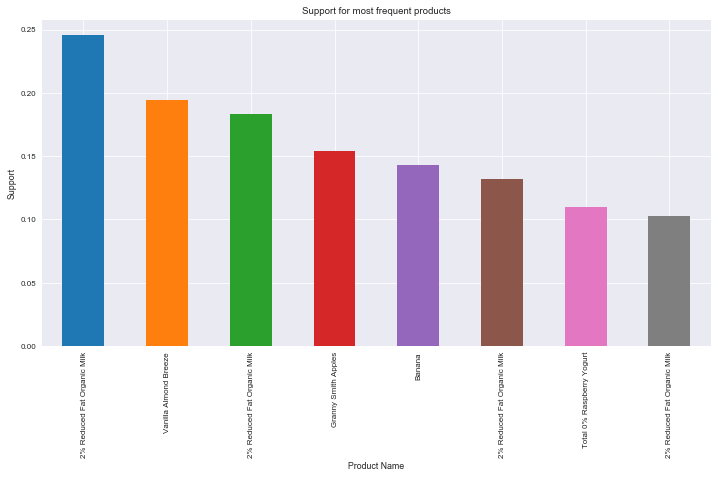

In [17]:
fig, ax = plt.subplots()
names = [n[0] for n in a["itemsets"]]
a['support'].plot.bar()
ax.set_xticklabels(names, rotation='vertical')
plt.title("Support for most frequent products")
plt.ylabel("Support")
plt.xlabel("Product Name")
plt.show()

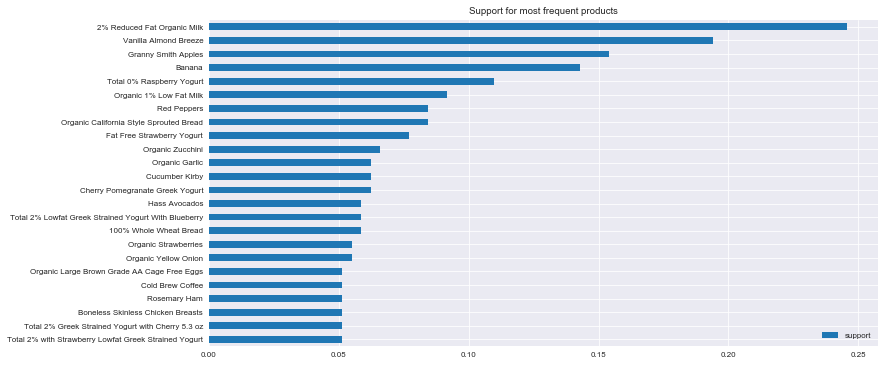

In [18]:
a = apriori(te_df, min_support=0.05, max_len=1, use_colnames=True) \
    .sort_values(by='support',ascending=False)
names = [n[0] for n in a["itemsets"]]
a.plot.barh(title ="Support for most frequent products")
plt.yticks(range(len(names)), names)
plt.gca().invert_yaxis()
plt.show()

### Rule Generation

In [19]:
frequent_itemsets = apriori(te_df, min_support=0.006,use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
print ("Generated {:,} rules".format(len(rules)))
rules.head()

Generated 75,272 rules


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Bagel Thins Everything),(2% Reduced Fat Organic Milk),0.014652,0.245421,0.014652,1.000000,4.074627,0.011056,inf
1,(Cherry Pomegranate Greek Yogurt),(2% Reduced Fat Organic Milk),0.062271,0.245421,0.062271,1.000000,4.074627,0.046988,inf
2,(Fat Free Strawberry Yogurt),(2% Reduced Fat Organic Milk),0.076923,0.245421,0.069597,0.904762,3.686567,0.050719,7.923077
3,(Fruit Punch Sports Drink),(2% Reduced Fat Organic Milk),0.014652,0.245421,0.014652,1.000000,4.074627,0.011056,inf
4,(G Series Perform Glacier Cherry Sports Drink),(2% Reduced Fat Organic Milk),0.014652,0.245421,0.014652,1.000000,4.074627,0.011056,inf


In [20]:
# get stats on objective measures
rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,75272.000000,75272.000000,75272.000000
mean,0.007735,0.999229,68.870895
std,0.002375,0.010801,45.595299
min,0.007326,0.800000,3.333786
25%,0.007326,1.000000,27.300000
50%,0.007326,1.000000,54.600000
75%,0.007326,1.000000,91.000000
max,0.183150,1.000000,136.500000


In [21]:
# order rules by lift
rules.sort_values(by='lift',ascending=False).head()

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
75271,"(Organic Leek, Yellow Onions)","(Organic Garlic, Organic Zucchini, Organic Pee...",0.007326,0.007326,0.007326,1.0,136.5,0.007272,inf
61404,"(Spaghetti, Organic American Cheese Singles, M...","(Kidz All Natural Baked Chicken Nuggets, Banan...",0.007326,0.007326,0.007326,1.0,136.5,0.007272,inf
61398,"(Clementines, Bag, Kidz All Natural Baked Chic...","(Spaghetti, Macaroni Shells & White Cheddar Ch...",0.007326,0.007326,0.007326,1.0,136.5,0.007272,inf
61399,"(Roasted Garlic Pasta Sauce, Kidz All Natural ...","(Spaghetti, Macaroni Shells & White Cheddar Ch...",0.007326,0.007326,0.007326,1.0,136.5,0.007272,inf
61400,"(Spaghetti, Macaroni Shells & White Cheddar Ch...","(Organic American Cheese Singles, Kidz All Nat...",0.007326,0.007326,0.007326,1.0,136.5,0.007272,inf
